In [46]:
!pip install tensorflow

In [47]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor

import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import Adam 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from keras.layers import LSTM
from sklearn.model_selection import KFold, cross_val_score, train_test_split

import pickle

In [48]:
model_df = pd.read_csv('../../Datasets/Bouletta/model_df.csv')

In [49]:
def tts(data):
    data = data.drop(['Total Profits','date'],axis=1)
    train, test = data[0:-12].values, data[-12:].values
    
    return train, test

train, test = tts(model_df)

In [50]:
train.shape

(11, 13)

In [51]:
test.shape

(12, 13)

In [52]:
def scale_data(train_set, test_set):
    #apply Min Max Scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train_set)
    
    # reshape training set
    train_set = train_set.reshape(train_set.shape[0], train_set.shape[1])
    train_set_scaled = scaler.transform(train_set)
    
    # reshape test set
    test_set = test_set.reshape(test_set.shape[0], test_set.shape[1])
    test_set_scaled = scaler.transform(test_set)
    
    X_train, y_train = train_set_scaled[:, 1:], train_set_scaled[:, 0:1].ravel()
    X_test, y_test = test_set_scaled[:, 1:], test_set_scaled[:, 0:1].ravel()
    
    return X_train, y_train, X_test, y_test, scaler

X_train, y_train, X_test, y_test, scaler_object = scale_data(train, test)

In [53]:
y_train.shape

(11,)

In [54]:
def undo_scaling(y_pred, x_test, scaler_obj, lstm=False):  
    #reshape y_pred
    y_pred = y_pred.reshape(y_pred.shape[0], 1, 1)
    
    if not lstm:
        x_test = x_test.reshape(x_test.shape[0], 1, x_test.shape[1])
    
    #rebuild test set for inverse transform
    pred_test_set = []
    for index in range(0,len(y_pred)):
        pred_test_set.append(np.concatenate([y_pred[index],x_test[index]],axis=1))
        
    #reshape pred_test_set
    pred_test_set = np.array(pred_test_set)
    pred_test_set = pred_test_set.reshape(pred_test_set.shape[0], pred_test_set.shape[2])
    
    #inverse transform
    pred_test_set_inverted = scaler_obj.inverse_transform(pred_test_set)
    
    return pred_test_set_inverted

In [55]:
def load_original_df():
    #load in original dataframe without scaling applied
    original_df = pd.read_csv("../../Datasets/Bouletta/train.csv")
    original_df.date = original_df.date.apply(lambda x: str(x)[:-3])
    original_df = original_df.groupby('date')['Total Profits'].sum().reset_index()
    original_df.Date = pd.to_datetime(original_df.date)
    return original_df

In [56]:
def predict_df(unscaled_predictions, original_df):
    #create dataframe that shows the predicted sales
    result_list = []
    sales_dates = list(original_df[-13:].date)
    act_sales = list(original_df[-13:]["Total Profits"])
    
    for index in range(0,len(unscaled_predictions)):
        result_dict = {}
        result_dict['pred_value'] = int(unscaled_predictions[index][0] + act_sales[index])
        result_dict['date'] = sales_dates[index+1]
        result_list.append(result_dict)
        
    df_result = pd.DataFrame(result_list)
    
    return df_result

In [57]:
model_scores = {}

def get_scores(unscaled_df, original_df, model_name):
    rmse = np.sqrt(mean_squared_error(original_df["Total Profits"][-12:], unscaled_df.pred_value[-12:]))
    mae = mean_absolute_error(original_df["Total Profits"][-12:], unscaled_df.pred_value[-12:])
    r2 = r2_score(original_df["Total Profits"][-12:], unscaled_df.pred_value[-12:])
    model_scores[model_name] = [rmse, mae, r2]

    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"R2 Score: {r2}")

In [58]:
def plot_results(results, original_df, model_name):

    fig, ax = plt.subplots(figsize=(15,5))
    sns.lineplot(original_df.date, original_df["Total Profits"], data=original_df, ax=ax, 
                 label='Original', color='mediumblue')
    sns.lineplot(results.date, results.pred_value, data=results, ax=ax, 
                 label='Predicted', color='Red')
    
    ax.set(xlabel = "date",
           ylabel = "Total Profits",
           title = f"{model_name} Sales Forecasting Prediction")
    
    ax.legend()
    
    sns.despine()
    
    plt.savefig(f'../../{model_name}_forecast.png')

In [59]:
def run_model(train_data, test_data, model, model_name):
    
    X_train, y_train, X_test, y_test, scaler_object = scale_data(train_data, test_data)
    
    mod = model
    mod.fit(X_train, y_train)
    predictions = mod.predict(X_test)
    
    # Undo scaling to compare predictions against original data
    original_df = load_original_df()
    unscaled = undo_scaling(predictions, X_test, scaler_object)
    unscaled_df = predict_df(unscaled, original_df)
      
    get_scores(unscaled_df, original_df, model_name)
    
    plot_results(unscaled_df, original_df, model_name)

C:\Users\Hp\AppData\Local\Temp\ipykernel_4708\2857936598.py:6: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  original_df.Date = pd.to_datetime(original_df.date)
C:\Users\Hp\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


RMSE: 4999.129743503697
MAE: 3839.9083333333333
R2 Score: -33.80405230146087


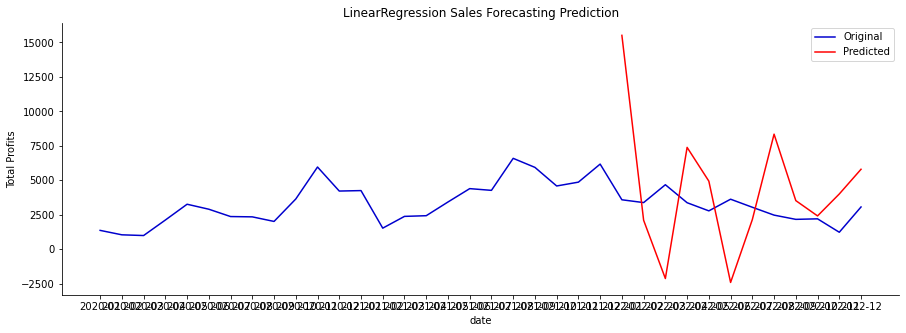

In [60]:
run_model(train, test, LinearRegression(), 'LinearRegression')

C:\Users\Hp\AppData\Local\Temp\ipykernel_4708\2857936598.py:6: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  original_df.Date = pd.to_datetime(original_df.date)
C:\Users\Hp\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


RMSE: 1375.920697466488
MAE: 1075.7216666666666
R2 Score: -1.6365001684066578


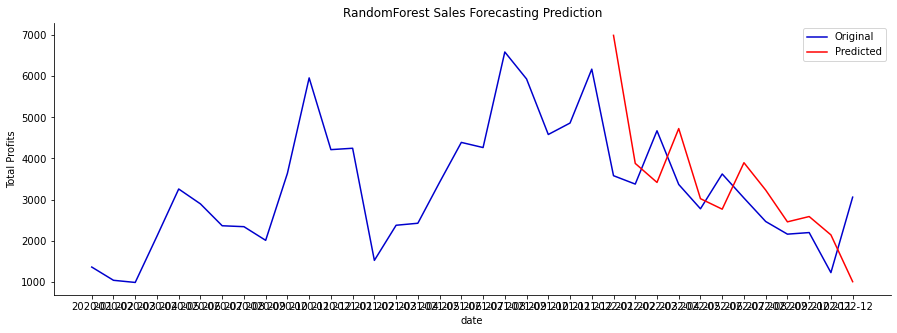

In [61]:
run_model(train, test, RandomForestRegressor(n_estimators=100, max_depth=20), 
          'RandomForest')

C:\Users\Hp\AppData\Local\Temp\ipykernel_4708\2857936598.py:6: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  original_df.Date = pd.to_datetime(original_df.date)
C:\Users\Hp\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


RMSE: 1757.0210914262432
MAE: 1493.7666666666667
R2 Score: -3.2992722328125312


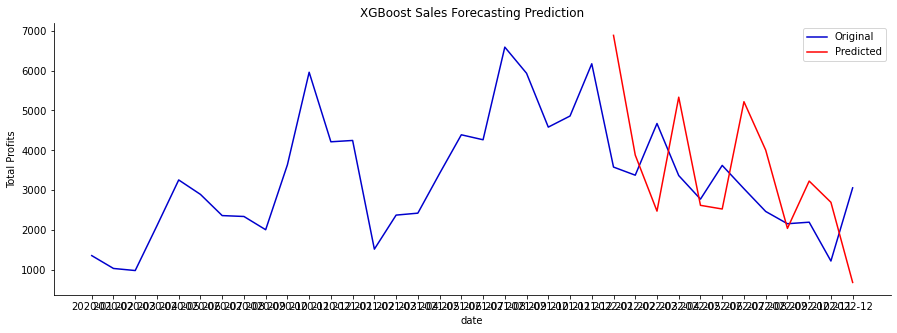

In [62]:
run_model(train, test, XGBRegressor( n_estimators=100, 
                                    learning_rate=0.2, 
                                    objective='reg:squarederror'), 'XGBoost')

In [63]:
def lstm_model(train_data, test_data):
    
    X_train, y_train, X_test, y_test, scaler_object = scale_data(train_data, test_data)
    
    X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
   
    model = Sequential()
    model.add(LSTM(4, batch_input_shape=(1, X_train.shape[1], X_train.shape[2]), 
                   stateful=True))
    model.add(Dense(1))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X_train, y_train, epochs=200, batch_size=1, verbose=1, 
              shuffle=False)
    predictions = model.predict(X_test,batch_size=1)
    
    original_df = load_original_df()
    unscaled = undo_scaling(predictions, X_test, scaler_object, lstm=True)
    unscaled_df = predict_df(unscaled, original_df)
    
    get_scores(unscaled_df, original_df, 'LSTM')
    
    plot_results(unscaled_df, original_df, 'LSTM')

Epoch 1/200
11/11 [==============================] - 7s 7ms/step - loss: 0.2754
Epoch 2/200
11/11 [==============================] - 0s 6ms/step - loss: 0.2621
Epoch 3/200
11/11 [==============================] - 0s 6ms/step - loss: 0.2568
Epoch 4/200
11/11 [==============================] - 0s 6ms/step - loss: 0.2522
Epoch 5/200
11/11 [==============================] - 0s 6ms/step - loss: 0.2479
Epoch 6/200
11/11 [==============================] - 0s 6ms/step - loss: 0.2438
Epoch 7/200
11/11 [==============================] - 0s 6ms/step - loss: 0.2399
Epoch 8/200
11/11 [==============================] - 0s 6ms/step - loss: 0.2362
Epoch 9/200
11/11 [==============================] - 0s 6ms/step - loss: 0.2325
Epoch 10/200
11/11 [==============================] - 0s 6ms/step - loss: 0.2290
Epoch 11/200
11/11 [==============================] - 0s 6ms/step - loss: 0.2255
Epoch 12/200
11/11 [==============================] - 0s 6ms/step - loss: 0.2221
Epoch 13/200
11/11 [=================

11/11 [==============================] - 0s 6ms/step - loss: 0.0056
Epoch 103/200
11/11 [==============================] - 0s 6ms/step - loss: 0.0052
Epoch 104/200
11/11 [==============================] - 0s 6ms/step - loss: 0.0048
Epoch 105/200
11/11 [==============================] - 0s 5ms/step - loss: 0.0044
Epoch 106/200
11/11 [==============================] - 0s 6ms/step - loss: 0.0041
Epoch 107/200
11/11 [==============================] - 0s 5ms/step - loss: 0.0038
Epoch 108/200
11/11 [==============================] - 0s 6ms/step - loss: 0.0035
Epoch 109/200
11/11 [==============================] - 0s 7ms/step - loss: 0.0032
Epoch 110/200
11/11 [==============================] - 0s 6ms/step - loss: 0.0030
Epoch 111/200
11/11 [==============================] - 0s 6ms/step - loss: 0.0027
Epoch 112/200
11/11 [==============================] - 0s 6ms/step - loss: 0.0025
Epoch 113/200
11/11 [==============================] - 0s 6ms/step - loss: 0.0023
Epoch 114/200
11/11 [=========

11/11 [==============================] - 0s 6ms/step - loss: 4.2839e-07
Epoch 199/200
11/11 [==============================] - 0s 6ms/step - loss: 3.7816e-07
Epoch 200/200
12/12 [==============================] - 2s 4ms/step
RMSE: 1994.7360929999406
MAE: 1570.4716666666666
R2 Score: -4.541302870193502


C:\Users\Hp\AppData\Local\Temp\ipykernel_4708\2857936598.py:6: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  original_df.Date = pd.to_datetime(original_df.date)
C:\Users\Hp\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


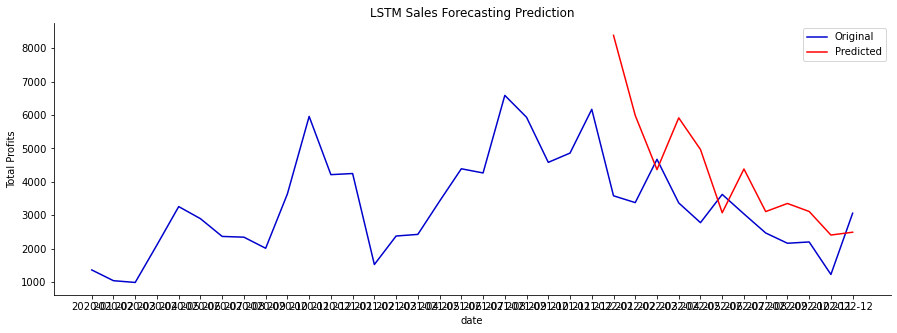

In [64]:
lstm_model(train, test)

In [65]:
pickle.dump(model_scores, open( "model_scores.p", "wb" ) )